## Pix2Pix from scratch

Данная модель раскрашивает героев симпсонов из черно-белых в цветные

В блокноте реализована модель на основе нескольких источников

- оригинальная статья

- видео с ютуб канала @AladdinPersson
 https://www.youtube.com/watch?v=9SGs4Nm0VR4 и https://www.youtube.com/watch?v=SuddDSqGRzg

В качесве датасета Использован journey_sprinfield https://www.kaggle.com/competitions/journey-springfield

In [3]:
# импорт нужных библиотек

import torch
import torch.nn as nn

In [4]:
# ЗАГРУЗКА ИЗОБРАЖЕНИЙ

# приделаем гугл драйв

import PIL
print(PIL.__version__)
from google.colab import drive
drive.mount('/content/gdrive/')
!unzip -q /content/gdrive/MyDrive/journey-springfield.zip
!ls train

9.4.0
Mounted at /content/gdrive/
simpsons_dataset


In [5]:
import numpy as np
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image

In [6]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [7]:
# создадим класс для изображений, возвращающих само изображение и его черно-белую копию

class SimpsonPix(Dataset):
    def __init__(self, files):
        self.files = sorted(files)

    def __len__(self):
        return len(self.files)

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):

        target_image = np.array(self.load_sample(self.files[index]))
        input_image = target_image

        target_transform = A.Compose(
            [A.Resize(width=256, height=256),
             A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),
             ToTensorV2()]
            )

        input_transform = A.Compose(
            [A.Resize(width=256, height=256),
             A.ToGray(p=1),
             A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),
             ToTensorV2()]
            )

        target_image = target_transform(image=target_image)["image"]
        input_image = input_transform(image=input_image)["image"]

        return input_image, target_image

In [8]:
from pathlib import Path
TRAIN_DIR = Path('./train/')
TEST_DIR = Path('./testset')
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [10]:
# тест как у алладина для проверки форм и цвета изображений

if __name__ == "__main__":
    dataset = SimpsonPix(train_val_files)
    loader = DataLoader(dataset, batch_size=5)
    for x, y in loader:
        print(x.shape)
        save_image(x, "x.png")
        save_image(y, "y.png")
        import sys

        sys.exit()

torch.Size([5, 3, 256, 256])


SystemExit: 

In [ ]:
# структура модели и трейн функции основаны на коде из ютуб канала

In [11]:
# ДИСКРИМИНАТОР

class DiscriminatorPix(nn.Module):
    def __init__(self):
        super().__init__()

        # in_channels=3*2 так как 3 - rgb, 2 - склейка образца с результатом
        self.dis0 = nn.Sequential(
            nn.Conv2d(in_channels=3*2, out_channels=64, kernel_size=4, stride=2, padding=1, padding_mode="reflect"),
            nn.LeakyReLU(0.2),
        )

        self.dis1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, bias=False,  padding_mode="reflect"),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
        )

        self.dis2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, bias=False,  padding_mode="reflect"),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
        )

        self.dis3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=1, bias=False,  padding_mode="reflect"),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
        )

        self.dis4 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=1, padding=1, padding_mode="reflect"),
        )


    def forward(self, x, y):

      x = torch.cat([x, y], dim=1)
      x = self.dis0(x)
      x = self.dis1(x)
      x = self.dis2(x)
      x = self.dis3(x)
      x = self.dis4(x)

      return x

In [ ]:
# тест для дискриминатора (как у Аладдина)

def test():
    x = torch.randn((1, 3, 256, 256))
    y = torch.randn((1, 3, 256, 256))
    model = DiscriminatorPix()
    preds = model(x, y)
    print(model)
    print(preds.shape)


if __name__ == "__main__":
    test()

DiscriminatorPix(
  (dis0): Sequential(
    (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (dis1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), bias=False, padding_mode=reflect)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (dis2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), bias=False, padding_mode=reflect)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (dis3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), bias=False, padding_mode=reflect)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (dis4): Sequential(
    (0): Conv2d(512, 1, kernel_size=(4, 4), stride

In [12]:
# ГЕНЕРАТОР

class GeneratorPix(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv0 = nn.Sequential(                                      # in 256*256*3 out ...
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1, padding_mode="reflect"),
            nn.LeakyReLU(0.2),
        )
        self.enc_conv1 =nn.Sequential(                                                   #  out
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False, padding_mode="reflect"),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            #nn.Dropout(0.5),
        )
        self.enc_conv2 =nn.Sequential(                                                   #  out
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False, padding_mode="reflect"),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            #nn.Dropout(0.5),
        )
        self.enc_conv3 =nn.Sequential(                                                   #  out
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False, padding_mode="reflect"),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            #nn.Dropout(0.5),
        )
        self.enc_conv4 =nn.Sequential(                                                   #  out
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False, padding_mode="reflect"),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            #nn.Dropout(0.5),
        )
        self.enc_conv5 =nn.Sequential(                                                   #  out
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False, padding_mode="reflect"),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            #nn.Dropout(0.5),
        )
        self.enc_conv6 =nn.Sequential(                                                   #  out
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False, padding_mode="reflect"),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            #nn.Dropout(0.5),
        )

        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False), #  out
            nn.ReLU(),
        )

        self.dec_conv0 =nn.Sequential(                                                   #  out
            nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
        )
        self.dec_conv1 =nn.Sequential(                                                   #  out
            nn.ConvTranspose2d(in_channels=512*2, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
        )
        self.dec_conv2 =nn.Sequential(                                                   #  out
            nn.ConvTranspose2d(in_channels=512*2, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
        )
        self.dec_conv3 =nn.Sequential(                                                   #  out
            nn.ConvTranspose2d(in_channels=512*2, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            #nn.Dropout(0.5),
        )
        self.dec_conv4 =nn.Sequential(                                                   #  out
            nn.ConvTranspose2d(in_channels=512*2, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            #nn.Dropout(0.5),
        )
        self.dec_conv5 =nn.Sequential(                                                   #  out
            nn.ConvTranspose2d(in_channels=512, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            #nn.Dropout(0.5),
        )
        self.dec_conv6 =nn.Sequential(                                                   #  out
            nn.ConvTranspose2d(in_channels=256, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            #nn.Dropout(0.5),
        )
        self.dec_conv7 =nn.Sequential(                                                   #  out
            nn.ConvTranspose2d(in_channels=128, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh(),
            #nn.Dropout(0.5),
        )

    def forward(self, x):
        d1 = self.enc_conv0(x)
        d2 = self.enc_conv1(d1)
        d3 = self.enc_conv2(d2)
        d4 = self.enc_conv3(d3)
        d5 = self.enc_conv4(d4)
        d6 = self.enc_conv5(d5)
        d7 = self.enc_conv6(d6)
        bottleneck = self.bottleneck_conv(d7)
        up1 = self.dec_conv0(bottleneck)
        up2 = self.dec_conv1(torch.cat([up1, d7], 1))
        up3 = self.dec_conv2(torch.cat([up2, d6], 1))
        up4 = self.dec_conv3(torch.cat([up3, d5], 1))
        up5 = self.dec_conv4(torch.cat([up4, d4], 1))
        up6 = self.dec_conv5(torch.cat([up5, d3], 1)) # up5 512
        up7 = self.dec_conv6(torch.cat([up6, d2], 1))
        up8 = self.dec_conv7(torch.cat([up7, d1], 1))
        return up8


In [ ]:
# тест для генератора (как у Аладдина)

def test():
    x = torch.randn((1, 3, 256, 256))
    model = GeneratorPix()
    preds = model(x)
    print(preds.shape)


if __name__ == "__main__":
    test()

torch.Size([1, 3, 256, 256])


In [13]:
# ТРЕНИРОВКА

# библиотеки и элементы конфигурации

device = "cuda" if torch.cuda.is_available() else "cpu"

In [14]:
device

'cuda'

In [15]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchvision.utils import save_image

In [16]:
disc = DiscriminatorPix().to(device)
gen = GeneratorPix().to(device)
opt_disc = optim.Adam(disc.parameters(), lr=2e-4, betas=(0.5, 0.999))
opt_gen = optim.Adam(gen.parameters(), lr=2e-4, betas=(0.5, 0.999))
bce = nn.BCEWithLogitsLoss()
l1_loss = nn.L1Loss()

In [17]:
train_dataset = SimpsonPix(train_val_files)
train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)
epochs = 50

In [ ]:
g_scaler = torch.cuda.amp.GradScaler()
d_scaler = torch.cuda.amp.GradScaler()

In [ ]:
def train_simp():
    for epoch in range(epochs):
      loop = tqdm(train_loader, leave=True)
      for idx, (x, y) in enumerate(loop):
          x = x.to(device)
          y = y.to(device)

          # Train Discriminator
          with torch.cuda.amp.autocast():
              y_fake = gen(x)
              D_real = disc(x, y)
              D_real_loss = bce(D_real, torch.ones_like(D_real))
              D_fake = disc(x, y_fake.detach())
              D_fake_loss = bce(D_fake, torch.zeros_like(D_fake))
              D_loss = (D_real_loss + D_fake_loss) / 2

          disc.zero_grad()
          d_scaler.scale(D_loss).backward()
          d_scaler.step(opt_disc)
          d_scaler.update()

          # Train generator
          with torch.cuda.amp.autocast():
              D_fake = disc(x, y_fake)
              G_fake_loss = bce(D_fake, torch.ones_like(D_fake))
              L1 = l1_loss(y_fake, y) * 100
              G_loss = G_fake_loss + L1

          opt_gen.zero_grad()
          g_scaler.scale(G_loss).backward()
          g_scaler.step(opt_gen)
          g_scaler.update()

          if idx % 10 == 0:
              loop.set_postfix(
                  D_real=torch.sigmoid(D_real).mean().item(),
                  D_fake=torch.sigmoid(D_fake).mean().item(),
              )
      if  epoch % 5 == 0:

        torch.save({
              'epoch': epoch,
              'model_state_dict': gen.state_dict(),
              'optimizer_state_dict': opt_gen.state_dict(),
              }, '/content/gdrive/MyDrive/GeneratorPix.pth')

        torch.save({
              'epoch': epoch,
              'model_state_dict': disc.state_dict(),
              'optimizer_state_dict': opt_disc.state_dict(),
              }, '/content/gdrive/MyDrive/DiscriminatorPix.pth')





In [ ]:
ddd=train_simp()

 50%|█████     | 2112/4187 [03:00<03:17, 10.52it/s, D_fake=0.00628, D_real=1]

In [ ]:
# проверим как учится модель и какие результаты дает, результат через 10 эпох

In [ ]:
# загрузка модели

model_load_disc = DiscriminatorPix()
optimizer_load_disc = optim.Adam(disc.parameters(), lr=2e-4, betas=(0.5, 0.999))

checkpoint = torch.load('/content/gdrive/MyDrive/DiscriminatorPix.pth')
model_load_disc.load_state_dict(checkpoint['model_state_dict'])
optimizer_load_disc.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
#loss = checkpoint['loss']

In [ ]:
model_load_gen =  GeneratorPix()
optimizer_load_gen = optim.Adam(gen.parameters(), lr=2e-4, betas=(0.5, 0.999))

checkpoint_1 = torch.load('/content/gdrive/MyDrive/GeneratorPix.pth')
model_load_gen.load_state_dict(checkpoint_1['model_state_dict'])
optimizer_load_gen.load_state_dict(checkpoint_1['optimizer_state_dict'])
epoch_1 = checkpoint_1['epoch']

In [18]:
# функция как у ааладина кот позволяет генерировать изображения, будем брать сразу из папки "тест"

from torchvision.utils import save_image

def save_some_examples(gen, val_loader, epoch, folder):
    x, y = next(iter(val_loader))
    x, y = x.to(device), y.to(device)
    gen.eval()
    with torch.no_grad():
        y_fake = gen(x)
        y_fake = y_fake * 0.5 + 0.5  # remove normalization#
        save_image(y_fake, folder + f"/y_gen_{epoch}.png")
        save_image(x * 0.5 + 0.5, folder + f"/input_{epoch}.png")
        if epoch == 1:
            save_image(y * 0.5 + 0.5, folder + f"/label_{epoch}.png")
    gen.train()

In [25]:
dataset_test = SimpsonPix(test_files)
val_loader = DataLoader(dataset_test, batch_size=1, shuffle=False)

In [ ]:
fff=save_some_examples(model_load_gen.to(device), val_loader, epoch=10, folder='/content/gdrive/MyDrive/')

результат


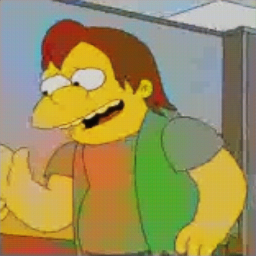

исходник, его лоадер переводит в грей валье и размеры меняет

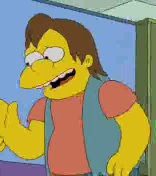

это изображение подается на генератор

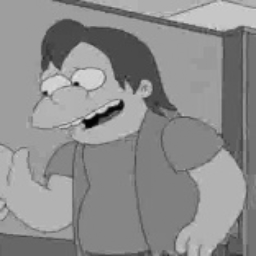

In [ ]:
# видимо проще - потренируем заново

In [ ]:
def train_simp_2():
    for epoch in range(epochs):
      loop = tqdm(train_loader, leave=True)
      for idx, (x, y) in enumerate(loop):
          x = x.to(device)
          y = y.to(device)

          # Train Discriminator
          with torch.cuda.amp.autocast():
              y_fake = gen(x)
              D_real = disc(x, y)
              D_real_loss = bce(D_real, torch.ones_like(D_real))
              D_fake = disc(x, y_fake.detach())
              D_fake_loss = bce(D_fake, torch.zeros_like(D_fake))
              D_loss = (D_real_loss + D_fake_loss) / 2

          disc.zero_grad()
          d_scaler.scale(D_loss).backward()
          d_scaler.step(opt_disc)
          d_scaler.update()

          # Train generator
          with torch.cuda.amp.autocast():
              D_fake = disc(x, y_fake)
              G_fake_loss = bce(D_fake, torch.ones_like(D_fake))
              L1 = l1_loss(y_fake, y) * 100
              G_loss = G_fake_loss + L1

          opt_gen.zero_grad()
          g_scaler.scale(G_loss).backward()
          g_scaler.step(opt_gen)
          g_scaler.update()

          if idx % 10 == 0:
              loop.set_postfix(
                  D_real=torch.sigmoid(D_real).mean().item(),
                  D_fake=torch.sigmoid(D_fake).mean().item(),
              )
      if  epoch % 5 == 0:

        torch.save({
              'epoch': epoch,
              'model_state_dict': gen.state_dict(),
              'optimizer_state_dict': opt_gen.state_dict(),
              'loss': G_loss,
              }, '/content/gdrive/MyDrive/GeneratorPix2.pth')

        torch.save({
              'epoch': epoch,
              'model_state_dict': disc.state_dict(),
              'optimizer_state_dict': opt_disc.state_dict(),
              'loss': D_loss,
              }, '/content/gdrive/MyDrive/DiscriminatorPix2.pth')





In [ ]:
# обучим сеть заново в течении 50 эпох

In [ ]:
dnkfnjf=train_simp_2()

100%|██████████| 4187/4187 [05:40<00:00, 12.31it/s, D_fake=0.00142, D_real=1]


In [ ]:
# проверрим как результат

In [23]:
model_load_gen_50 =  GeneratorPix()
optimizer_load_gen_50 = optim.Adam(gen.parameters(), lr=2e-4, betas=(0.5, 0.999))

checkpoint_50 = torch.load('/content/gdrive/MyDrive/GeneratorPix2.pth')
model_load_gen_50.load_state_dict(checkpoint_50['model_state_dict'])
optimizer_load_gen_50.load_state_dict(checkpoint_50['optimizer_state_dict'])
epoch_50 = checkpoint_50['epoch']

In [20]:

from torchvision.utils import save_image

def save_some_examples(gen, val_loader, epoch, folder):
    x, y = next(iter(val_loader))
    x, y = x.to(device), y.to(device)
    gen.eval()
    with torch.no_grad():
        y_fake = gen(x)
        y_fake = y_fake * 0.5 + 0.5  # remove normalization#
        save_image(y_fake, folder + f"/y_gen_{epoch}.png")
        save_image(x * 0.5 + 0.5, folder + f"/input_{epoch}.png")
        if epoch == 1:
            save_image(y * 0.5 + 0.5, folder + f"/label_{epoch}.png")
    gen.train()

In [ ]:
ghvhjvjv=save_some_examples(model_load_gen_50.to(device), val_loader, epoch=50, folder='/content/gdrive/MyDrive/')

после 50 циклов есть артефакты но результат лучше чем через 15

это изображение после 50 циклов
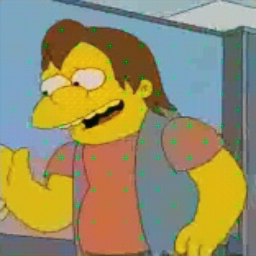

In [ ]:
# теперь необходимо оценить качесво результатов какой либо метрикой
# например взять метрику из готовой библиотеки https://piq.readthedocs.io/en/latest/overview.html

In [1]:
pip install piq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.9/106.9 kB 2.9 MB/s eta 0:00:00


In [2]:
from piq import ssim

In [19]:
from piq import psnr

In [ ]:
# пример использования ssim_index = piq.ssim(x, y, data_range=1.)
# psnr_index = piq.psnr(x, y, data_range=1., reduction='none')

In [41]:
# функция которая возвращает тензоры нормализованные после генерации

def save_some_examples_and_return_some_tensoers (gen, val_loader, epoch, folder):
    x, y = next(iter(val_loader))
    x, y = x.to(device), y.to(device)
    gen.eval()
    with torch.no_grad():
        y_fake_1 = gen(x)
        y_fake = y_fake_1 * 0.5 + 0.5  # remove normalization#
        save_image(y_fake, folder + f"/y_gen_{epoch}.png")
        save_image(x * 0.5 + 0.5, folder + f"/input_{epoch}.png")
        if epoch == 1:
            save_image(y * 0.5 + 0.5, folder + f"/label_{epoch}.png")
    gen.train()

    x_mother = y
    save_image (x_mother * 0.5 + 0.5, folder + f"/input_mother_{epoch}.png")
    return x, y_fake_1, x_mother

In [42]:
d1, d2, d3 = save_some_examples_and_return_some_tensoers (model_load_gen_50.to(device), val_loader, epoch=55, folder='/content/gdrive/MyDrive/')

In [48]:
# приведем значения тензоров к 0 до 255 чтобы использовать метрику

d3_255=d3 * 0.5 + 0.5
d2_255=d2 * 0.5 + 0.5

In [51]:
ssim_index = ssim(d3_255, d2_255, data_range=1.)
ssim_index

tensor(0.8572, device='cuda:0')

In [57]:
psnr_index = psnr(d3_255, d2_255, data_range=1., reduction='none')
psnr_index

tensor([23.1481], device='cuda:0')

In [ ]:
# очень даже и неплохо значнения метрик высокие
# ssim_index  max 1 полное совпадение
# psnr_index при сравнении само с обой дает 80 , а у меня шумненько

In [80]:
# посмотрим метрику сквозь весь датасет

def return_some_metrics (gen, val_loader, epoch, folder):
    ssim_index_all=[]
    psnr_index_all=[]
    it_val=iter(val_loader)
    for i in range(len(test_files)): #
        x, y = next(it_val)
        x, y = x.to(device), y.to(device)
        gen.eval()
        with torch.no_grad():
            y_fake_1 = gen(x)
            y_fake = y_fake_1 * 0.5 + 0.5  # remove normalization#
            #save_image(y_fake, folder + f"/y_gen_m_{i}.png")
            #save_image(x * 0.5 + 0.5, folder + f"/input__m{i}.png")
            #if epoch == 1:
                #save_image(y * 0.5 + 0.5, folder + f"/label_{epoch}.png")
        gen.train()

        x_mother = y
        #save_image (x_mother * 0.5 + 0.5, folder + f"/input_mother_{i}.png")

        y_fake_1=y_fake_1 * 0.5 + 0.5
        x_mother=x_mother * 0.5 + 0.5

        ssim_index = ssim(y_fake_1, x_mother, data_range=1.).cpu().numpy()
        psnr_index = psnr(y_fake_1, x_mother, data_range=1., reduction='none').cpu().numpy()

        ssim_index_all.append(ssim_index)
        psnr_index_all.append(psnr_index)

    return ssim_index_all, psnr_index_all

In [81]:
ssim_test_simp, psnr_test_simpnnn = return_some_metrics (model_load_gen_50.to(device), val_loader, epoch=55, folder='/content/gdrive/MyDrive/')


In [86]:
# среднее значение метрики по всему тест сету
np.mean(ssim_test_simp)

0.84047586

In [87]:
# среднее значение метрики по всему тест сету
np.mean(psnr_test_simpnnn)

24.011412